In [ ]:
##### Copyright 2021 The Cirq Developers

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Identifying Drift

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/tutorials/google/identifying_drift"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/tutorials/google/identifying_drift.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/tutorials/google/identifying_drift.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/google/identifying_drift.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

You've run your circuit with Google's [Quantum Computing Service](./start.ipynb) and you are getting unusual or unexpected results. What's the cause of this and what can you do about it? 

Your experience may be due to [qubit drift](../../google/calibration_faq.md). This refers to a meaningful change in the qubit's performance or fidelity, and can occur in both gate and readout operations, changing their rate of failure. These changes can occur on the order of days or even minutes.

Superconducting qubits are each tuned to a particular frequency, and occasionally other [two-level systems](https://en.wikipedia.org/wiki/Two-state_quantum_system) in their vicinity can resonate at the same frequency. These TLS can steal or share energy with the qubit, causing it to change it's quantum state. The causes of temporary, inconsistent TLS is an area of active research, but they are thought to be most often caused by defects and inconsistencies in the material making up the qubit and surrounding hardware (though this is a gross oversimplification of many interacting factors). Another source of potential drift is DC Bias, which refers to minute changes of voltage in the control hardware, which changes the frequency of the qubit, affecting it's fidelity. For more information on these phenomena, see [arXiv:1809.01043](https://arxiv.org/abs/1809.01043).

Maintenance [Calibration](./calibration_api.ipynb) runs at periodic intervals (e.g. at most daily) in order to tune each qubit to good frequencies (those with few other interfering two-level systems). However, these good frequencies could have changed in the hours or days since the previous calibration, decreasing the performance of the qubits. 

As a user, you can combat this through careful qubit selection. Our [Best Practices](../../google/best_practices.md) guide and [Qubit Picking with Loschmidt Echoes](./echoes.ipynb) and [Optimization, Alignment and Spin Echoes](./spin_echoes.ipynb) tutorials can provide more information on the qubit selection process. This tutorial details how to _characterize_ qubit operation performance by collecting and comparing two-qubit gate and readout operation error rates. One can then use this data to identify when qubit drift has occurred, and to inform qubit selection decisions.

# Qubit Error Metrics

This tutorial will focus on the following two metrics for our examples:

*    Two Qubit Sqrt ISWAP XEB Pauli Error: For a particular pair of qubits, when we apply a $\sqrt{i\mathrm{SWAP}}$ gate, the Pauli error is the estimated probability with which the quantum state will depolarize as if a Pauli gate was applied to one or more of the qubits. We collect this measure with [Cross Entropy Benchmarking](../../qcvv/xeb_theory.ipynb) aka XEB because this is the method used during maintenance calibration
*    Parallel P11 Error: For each single qubit, we initialize the qubit to $|1⟩$ and measure the frequency with which the qubit's readout operation measures a $|1⟩$ state. The P11 error is the expected probability that the readout does not correctly measure $|1⟩$. We perform this experiment for all the qubits simultaneously, or in parallel. 

The first metric is applicable if your circuit is compiled using $\sqrt{i\mathrm{SWAP}}$ gates, but the Sycamore gate is also supported for benchmarking. You can also run the much slower isolated version of the experiment, where qubit pairs are not tested in parallel. Finally, each test can return any of the multiplicatively-related metrics: [Average Error, Pauli Error, or Incoherent Error](../../google/calibration.md#average-pauli-and-incoherent-error).

Other single-qubit metrics exist as well, including Parallel P00 error, isolated versions of the P00 and P11 errors, separation error, and one-qubit randomized benchmarking error. 

Our [Calibration Metrics](../../google/calibration.md#individual-metrics) guide discusses the error data metrics available, as well as the types of error available. Our [Visualizing Calibration Metrics](./visualizing_calibration_metrics.ipynb) tutorial demonstrates how to collect and visualize each of the available metrics. You can apply this tutorial's comparison methods to any of these metrics. 

At the end of the tutorial we'll discuss some of the example conclusions one can draw based on the maintenance calibration and collected characterization data, and how those conclusions can inform qubit selection.

**Disclaimer**: The data shown in this tutorial is an example and not representative of the QCS in production.

## Setup

First, we install Cirq and import the packages we will use.

Note: this notebook relies on unreleased Cirq features. If you want to try these features, make sure you install cirq via `pip install cirq --pre`.

In [ ]:
try:
    import cirq
except ImportError:
    !pip install --quiet cirq --pre

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import cirq
import cirq_google as cg

Next, we authorize to use the Quantum Computing Service and acquire a sampler to run our experiments. Set the number of repetitions we'll use for all experiments. Note that you can select a subset of the qubits to shorten the runtime of the experiment.

In [ ]:
# Set key variables
project_id = '' #@param {type:"string"}
processor_id = "" #@param {type:"string"}
repetitions = 2000 #@param {type:"integer"}

# Get device sampler
from cirq_google.engine.qcs_notebook import get_qcs_objects_for_notebook

qcs_objects = get_qcs_objects_for_notebook(project_id=project_id, processor_id=processor_id)

device = qcs_objects.device
sampler = qcs_objects.sampler

# Get qubit set
qubits = device.qubit_set()

# Limit device qubits to only those before row/column 6
#lim = 6
#qubits = {qb for qb in qubits if qb.row<lim and qb.col<lim}

Getting OAuth2 credentials.
Press enter after entering the verification code.
Authentication complete.


We query for the calibration data with [`cirq_google.get_engine_calibration`](https://quantumai.google/reference/python/cirq_google/engine/get_engine_calibration), select our two metrics by name from the calibration object, and visualize them with [`calibration.plot(metric_name)`](https://quantumai.google/reference/python/cirq_google/engine/Calibration#plot). 

(<Figure size 1440x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4ecaa2ed0>,
       dtype=object))

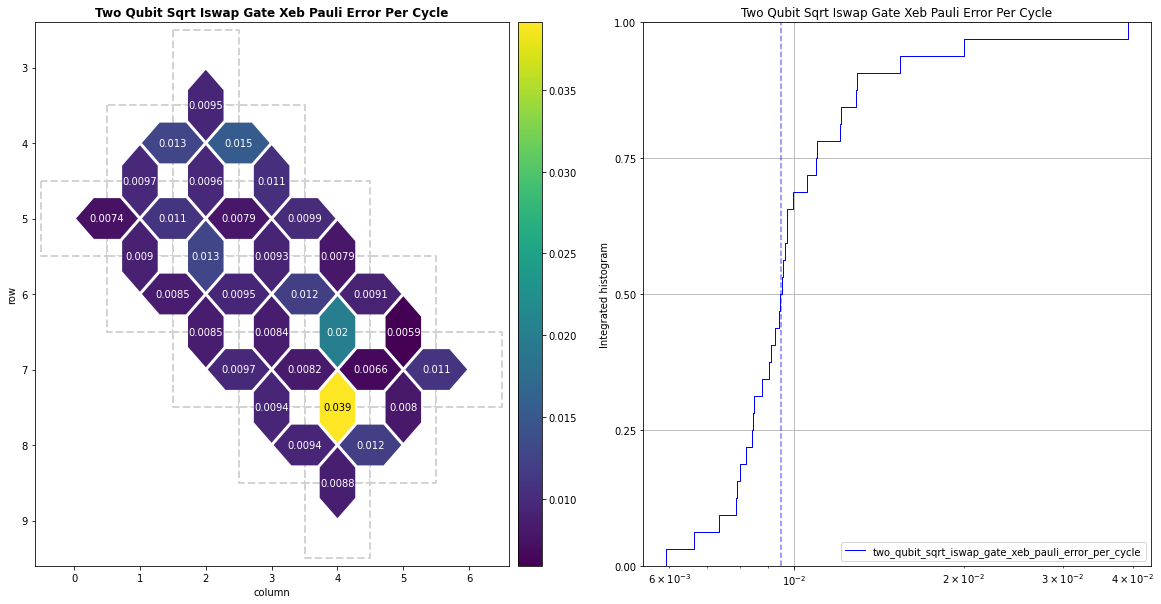

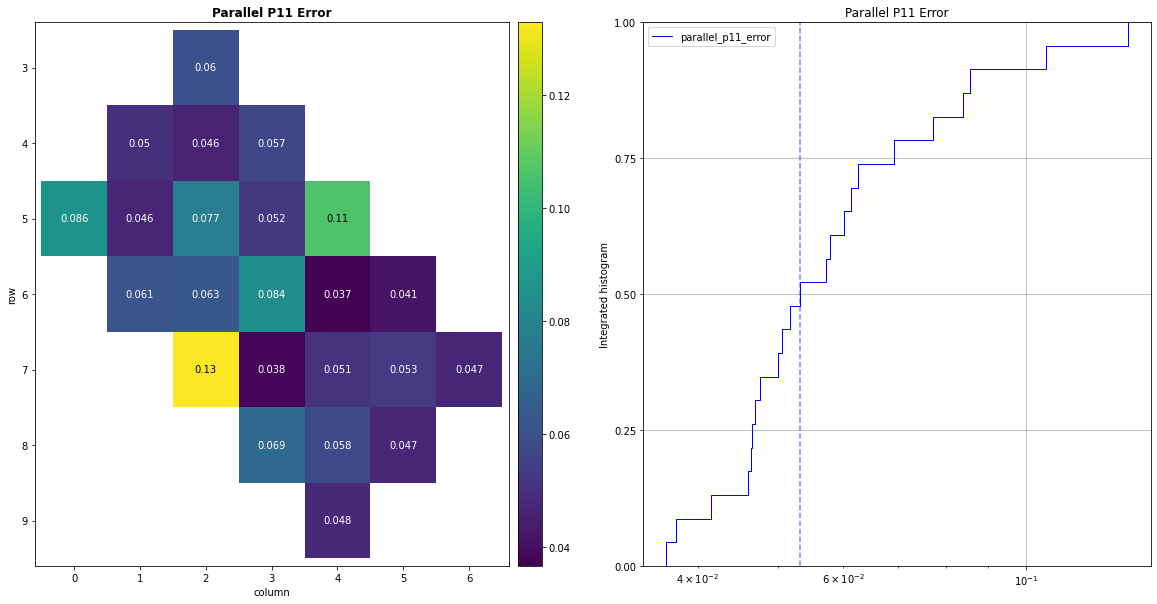

In [ ]:
# Retreive maintenance calibration data.
calibration = cg.get_engine_calibration(processor_id=processor_id)

# Heatmap our two metrics.
two_qubit_gate_metric = "two_qubit_sqrt_iswap_gate_xeb_pauli_error_per_cycle" #@param {type:"string"}
readout_metric = "parallel_p11_error" #@param {type:"string"}

# Plot heatmaps with integrated histogram
calibration.plot(two_qubit_gate_metric, fig=plt.figure(figsize=(20, 10)))
calibration.plot(readout_metric, fig=plt.figure(figsize=(20, 10)))

You may have already seen this existing maintenance calibration data, when you did qubit selection in the first place. We'll now run characterization experiments to collect the same data metrics from the device, to see if their values have changed since the previous calibration. We'll start with the two-qubit metric, which we collect with Parallel XEB.

## Parallel XEB

This section is a shortened version of the [Parallel XEB](../../qcvv/parallel_xeb.ipynb) tutorial. First, we generate a library of two qubit circuits using the gate type we are analyzing ($\sqrt{i\mathrm{SWAP}}$). these circuits will be run in parallel in larger circuits according to `combs_by_layer`. 

In [ ]:
"""Setup for parallel XEB experiment."""
from cirq.experiments import random_quantum_circuit_generation as rqcg
from itertools import combinations

random_seed = 52

# Generate library of two-qubit XEB circuits.
circuit_library = rqcg.generate_library_of_2q_circuits(
    n_library_circuits=20, 
    two_qubit_gate=cirq.SQRT_ISWAP,
    random_state=random_seed,
)

def qubits_to_grid_graph(qubits):  
    return nx.Graph((q1,q2) for (q1,q2) in combinations(qubits, 2) if q1.is_adjacent(q2))

# Generate different possible pairs of qubits, and randomly assign circuit (indices) to then, n_combinations times. 
combs_by_layer = rqcg.get_random_combinations_for_device(
    n_library_circuits=len(circuit_library),
    n_combinations=10,
    device_graph=qubits_to_grid_graph(qubits),
    random_state=random_seed,
)
# Prepare the circuit depths we will truncate our circuits to. 
cycle_depths = np.arange(3, 100, 20)

Then, we run the circuits on our device, combining them into larger circuits and truncating the circuits by length, with [`sample_2q_xeb_circuits`](https://quantumai.google/reference/python/cirq/experiments/xeb_sampling/sample_2q_xeb_circuits). 

Afterwards, we run the same circuits on a perfect simulator, and compare them to our sampled results. Finally, the collected data is fit to an exponential decay curve to estimate the error rate per appication of each two-qubit $\sqrt{i\mathrm{SWAP}}$ gate. 

In [ ]:
"""Collect all data by executing circuits."""
from cirq.experiments.xeb_sampling import sample_2q_xeb_circuits
from cirq.experiments.xeb_fitting import benchmark_2q_xeb_fidelities, fit_exponential_decays

# Run XEB circuits on the processor.
sampled_df = sample_2q_xeb_circuits(
    sampler=sampler,
    circuits=circuit_library,
    cycle_depths=cycle_depths,
    combinations_by_layer=combs_by_layer,
    shuffle=np.random.RandomState(random_seed),
    repetitions=repetitions,
)

# Run XEB circuits on a simulator and fit exponential decays.
fids = benchmark_2q_xeb_fidelities(
    sampled_df=sampled_df,
    circuits=circuit_library,
    cycle_depths=cycle_depths,
)
fidelities = fit_exponential_decays(fids)

100%|██████████| 207/207 [09:08<00:00,  2.65s/it]


We can visualize these results [Heatmaps](../../tutorials/heatmaps.ipynb) as below. Note: The parallel XEB errors are scaled in pxeb_results. This is because the collected fidelities are the estimated depolarization fidelities, not the Pauli error metrics we're looking for. See the [XEB Theory](../../qcvv/xeb_theory.ipynb) tutorial for an explanation why, and [Calibration Metrics](../../google/calibration.md) for more on the difference between these values. 

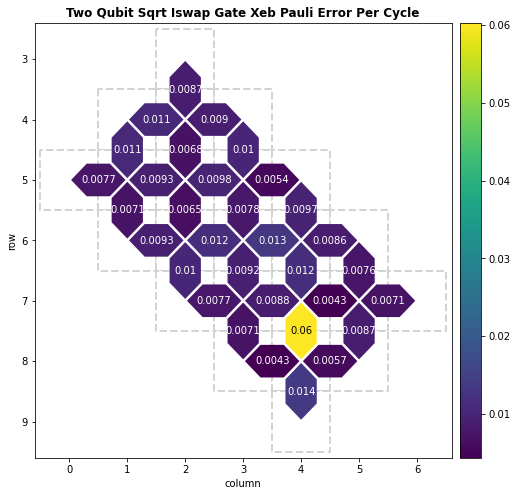

In [ ]:
#Grab (pair, sqrt_iswap_pauli_error_per_cycle) data for all qubit pairs.
pxeb_results = {
    pair: (1.0 - fidelity) / (4 / 3) #Scalar to get Pauli error
    for (_, _, pair), fidelity in fidelities.layer_fid.items()
}

cirq.TwoQubitInteractionHeatmap(pxeb_results).plot(
    title=two_qubit_gate_metric.replace("_", " ").title()
);

# Simultaneous Readout

We'll collect the Parallel P11 error data for each qubit with the internal Simultaneous Readout protocol, accessible easily with [`estimate_parallel_single_qubit_readout_errors`](https://quantumai.google/reference/python/cirq/experiments/estimate_single_qubit_readout_errors). This function runs the experiment to estimate P00 and P11 errors for each qubit (as opposed to querying for the most recent calibration data). The experiment is simple, measuring each qubit in the $|0⟩$ and $|1⟩$ states, and evaluating how often the qubit is measured in the expected state. 

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff4ecc0e450>,
 <matplotlib.collections.PolyCollection at 0x7ff4ecc78110>)

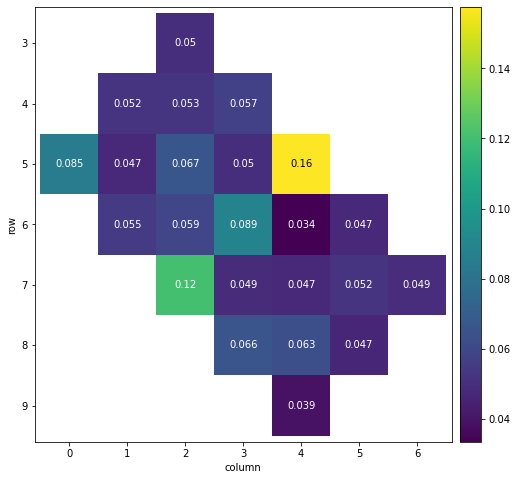

In [ ]:
sq_result = cirq.estimate_parallel_single_qubit_readout_errors(sampler, qubits=qubits, repetitions=repetitions)

#cirq.Heatmap(sq_result.zero_state_errors).plot()
cirq.Heatmap(sq_result.one_state_errors).plot()

## Heatmap comparison

In order to get a fair comparison, we plot the now four heatmap graphs we've collected side by side, on the same scale. 

Text(0.5, 0.5, 'Parallel P11 Error')

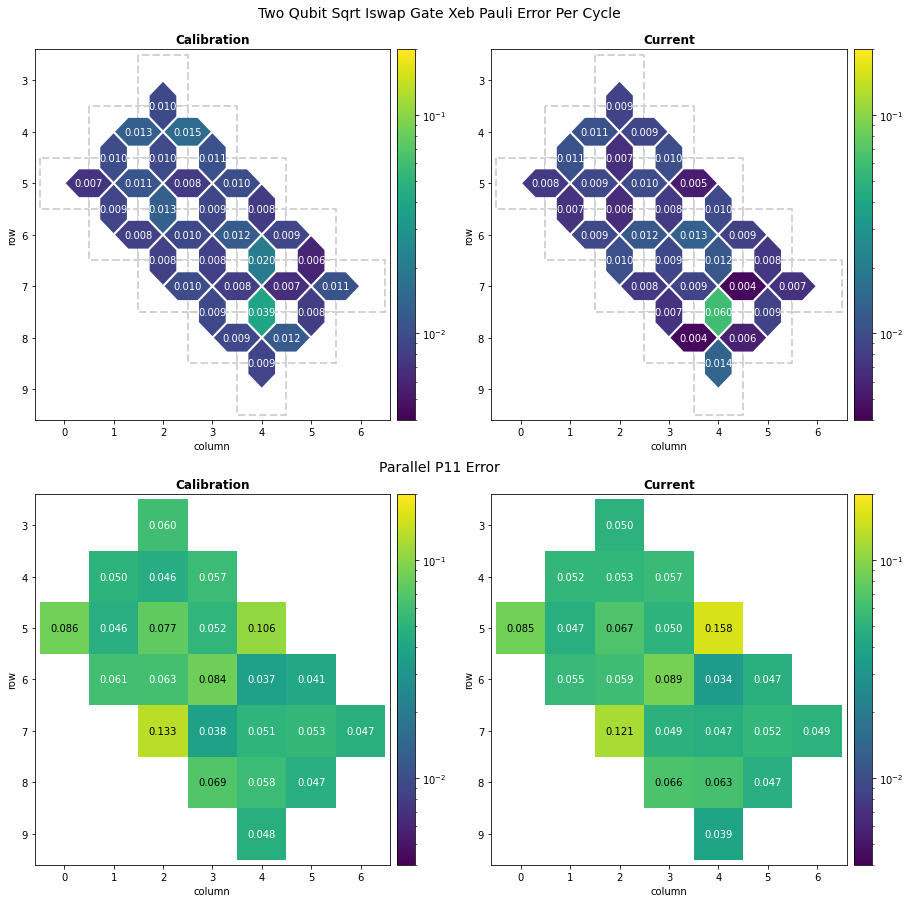

In [ ]:
from matplotlib.colors import LogNorm

# Plot options.
vmin = 4e-3
vmax = 2e-1
options = {"norm": LogNorm()}
format = "0.3f"

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# Calibration Two Qubit SQRT_ISWAP Data
calibration.heatmap(two_qubit_gate_metric).plot(
  ax=ax1, title="Calibration", vmin=vmin, vmax=vmax, 
  collection_options=options, annotation_format=format,
)
# Current Two Qubit SQRT_ISWAP Data
cirq.TwoQubitInteractionHeatmap(pxeb_results).plot(
  ax=ax2, title="Current", vmin=vmin, vmax=vmax, 
  collection_options=options, annotation_format=format,
)

# Calibration Readout Data
calibration.heatmap(readout_metric).plot(
  ax=ax3, title="Calibration", vmin=vmin, vmax=vmax, 
  collection_options=options, annotation_format=format,
)

# Current Readout Data
cirq.Heatmap(sq_result.one_state_errors).plot(
  ax=ax4, title="Current", vmin=vmin, vmax=vmax, 
  collection_options=options, annotation_format=format,
)

# Add titles
plt.figtext(0.5,0.92, two_qubit_gate_metric.replace("_"," ").title(), ha="center", va="top", fontsize=14)
plt.figtext(0.5,0.5, readout_metric.replace("_"," ").title(), ha="center", va="top", fontsize=14)


## Heatmap Observations

The heatmaps provide a easy visual comparison for identifying qubit and qubit pair performance. The comparison with the previous maintenance calibration data allows us to identify which qubits have changed in performance (drifted!). 

Remembering that lighter colors refer to worse performance (higher Pauli/readout error), we notice that the worst qubit for readouts in the maintenance calibration, qubit $Q(7,2)$, has improved it's performance slightly, but not by much. It is also no longer the worst readout qubit, as that award goes to $Q(5,4)$. We definitely want to avoid using these qubits for readout. Outside of the middle of the graph, we see a mixed bag of readout error changes. The top of the graph seems to be nearly the same in the current data as in the calibration, with a tend towards slightly less error. The bottom right of the graph shows some qubits improving: $[Q(9,4), Q(7,4), Q(6,4)]$, and others deteriorating: $[Q(8,4), Q(7,3), Q(6,5)]$. 

For two-qubit $\sqrt{i\mathrm{SWAP}}$ gates, the $(Q(7,4),Q(8,4))$ pair has worsened by a large margin, but two adjacent pairs, $(Q(8,3),Q(8,4))$ and $(Q(8,4),Q(8,5))$, have each improved noticeably by at least 0.005. The $(Q(7,4),Q(8,4))$ pair is in fact so bad that it may be preferable to perform two SWAP operations on qubit pairs $(Q(7,4),Q(7,5))$ and $(Q(8,4),Q(8,5)$, and then finally perfom the desired $\sqrt{i\mathrm{SWAP}}$ gate on qubit pair $(Q(7,5)Q(8,5)$ instead. However, this may require shifting the rest of the circuit around on the device, which is part of why qubit mapping is such a hard problem. 

Considering both datasets together, it seems like the top and bottom right of the readout graphs demonstrate the lowest error for readout. The two-qubit pairs at the top of the graph seem to have become a meaningfully more accurate since the most recent calibration. Those in the bottom right have also improved, but more inconsistently. The top of the graph seems like it has both consistently reasonable readouts and $\sqrt{i\mathrm{SWAP}}$ operations. 

A circuit mapped to this graph would likely perform best if it positioned the most of it's two-qubit $\sqrt{i\mathrm{SWAP}}$ gates towards the top of the device. If the circuit has more readout qubits than can fit in the top of the graph, those additional logical qubits would likely want to be placed on the hardware qubits that are towards the right of the device. While connecting these two regions together, one would want to avoid using the worst $\sqrt{i\mathrm{SWAP}}$ pair in the middle or putting readouts on the qubits in the middle that have more than around 0.07 P11 error. 

If your collected characterization data differs very significantly from the _scale_ of drift shown in our examples, the system may have drifted too far from calibration to be reasonably usable. In this case, please email the quantum engine support team to let them know. 

# What's Next?

So you've selected new, better qubits for your circuit, based on current, up to date information about the device. What else can you do for further improvements? 

*    You need to map your actual circuit's logical qubits to your selected hardware qubits. This is in general a difficult problem, and the best solution can depend on the specific structure of the circuit to be run. Take a look at our [Qubit Picking with Loschmidt Echoes](./echoes.ipynb) tutorial. It adds Loschmidt Echoes to Parallel XEB to estimate the error rates of gates for your specific circuit. Also, consider [Best Practices#Qubit picking](../../google/best_practices.md#qubit-picking) for additional advice. 
*    Our [Optimization, Alignment, and Spin Echoes](./spin_echoes.ipynb) tutorial provides resources on how you can improve the reliability of your circuit by: optimizing away redundant or low-impact gates, aligning gates into moments with others of the same type, and preventing decay on idle qubits with by adding spin echoes. 
*    Other than for qubit picking, you can also use the Calibraiton API for error compensation. In the [XEB and Coherent Error](../../qcvv/xeb_coherent_noise.ipynb), [XEB Calibration Example](./xeb_calibration_example.ipynb), [Parallel XEB](../../qcvv/parallel_xeb.ipynb) and [Isolated XEB](../../qcvv/isolated_xeb.ipynb) tutorials, we demonstrate how to run a classical optimizer on collected two-qubit gate characterization data, identity the true unitary matrix implemented by each gate, and add [Virtual Pauli Z gates](../../google/devices.md#virtual-z-gates) to compensate for the identified error. 
*    You are also free to use the characterization data to improve the performance of large batches of experiment circuits. In this case you'd want to prepare your characterization ahead of running all your circuits, and use the data to compensate each circuit, right before running them. See [Calibration FAQ](../../google/calibration_faq.md#i-have-many-circuits-to-calibrate-how-do-i-speed-it-up) for more information. 